## DeepLabV3+

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def deeplabv3plus_model(input_shape=(512, 512, 3), num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Salida del encoder
    low_level_feat = base_model.get_layer('conv2_block1_out').output  # 64x64
    low_level_feat = Conv2D(48, 1, activation='relu', padding='same')(low_level_feat)

    encoder_output = base_model.get_layer('conv5_block3_out').output  # 32x32

    # ASPP
    pool = tf.keras.layers.GlobalAveragePooling2D()(encoder_output)
    pool = Reshape((1, 1, pool.shape[-1]))(pool)
    pool = Conv2D(256, 1, activation='relu', padding='same')(pool)
    pool = UpSampling2D(size=(encoder_output.shape[1], encoder_output.shape[2]))(pool)

    conv1 = Conv2D(256, 1, dilation_rate=1, activation='relu', padding='same')(encoder_output)
    conv6 = Conv2D(256, 3, dilation_rate=6, activation='relu', padding='same')(encoder_output)
    conv12 = Conv2D(256, 3, dilation_rate=12, activation='relu', padding='same')(encoder_output)
    conv18 = Conv2D(256, 3, dilation_rate=18, activation='relu', padding='same')(encoder_output)

    aspp = Concatenate()([pool, conv1, conv6, conv12, conv18])

    # ASPP Output
    aspp = Conv2D(256, 1, activation='relu', padding='same')(aspp)

    # 🔥 ¡Subir de 16x16 -> 64x64!
    x = UpSampling2D(size=(4,4))(aspp)

    # Concatenar ASPP upsampleado con low_level_feat
    x = Concatenate()([x, low_level_feat])

    # Decoder convolutions
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    # Upsample final: 64x64 → 256x256
    x = UpSampling2D(size=(4,4))(x)

    # Capa de salida
    outputs = Conv2D(num_classes, (1,1), activation='sigmoid', padding='same')(x)

return Model(inputs=base_model.input, outputs=outputs)


SyntaxError: 'return' outside function (265109297.py, line 47)

## Attention U-Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Concatenate, Add, Multiply
from tensorflow.keras.models import Model

In [ ]:
# Attention U-Net
def build_attention_unet(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D(pool_size=(2,2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D(pool_size=(2,2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D(pool_size=(2,2))(c3)

    c4 = conv_block(p3, 512)

    # Decoder
    u3 = UpSampling2D(size=(2,2))(c4)
    att3 = attention_gate(c3, u3, inter_channels=128)
    m3 = Concatenate()([u3, att3])
    c5 = conv_block(m3, 256)

    u2 = UpSampling2D(size=(2,2))(c5)
    att2 = attention_gate(c2, u2, inter_channels=64)
    m2 = Concatenate()([u2, att2])
    c6 = conv_block(m2, 128)

    u1 = UpSampling2D(size=(2,2))(c6)
    att1 = attention_gate(c1, u1, inter_channels=32)
    m1 = Concatenate()([u1, att1])
    c7 = conv_block(m1, 64)

    outputs = Conv2D(num_classes, 1, activation='sigmoid', padding='same')(c7)

    model = Model(inputs, outputs)
    return model

## Mask R-CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_mask_rcnn_light(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder (similar a ResNet pequeño)
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    # RPN (Region Proposal Network) - Simulada como características globales
    rpn = GlobalAveragePooling2D()(x)
    rpn = Dense(128, activation='relu')(rpn)
    rpn = Dense(4, activation='linear', name='rpn_bbox')(rpn)  # output: (x, y, w, h)

    # Head de segmentación (mask branch)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2,2))(x)
    masks = Conv2D(num_classes, 1, activation='sigmoid', name='mask')(x)  # Salida de máscaras

    # Modelo
    model = Model(inputs=inputs, outputs=[rpn, masks])
    return model

In [ ]:
model_mask_rcnn_light = build_mask_rcnn_light()

model_mask_rcnn_light.compile(
    optimizer='adam',
    loss={
        'rpn_bbox': 'mse',           # Pérdida de regresión para bounding boxes (dummy aquí)
        'mask': 'binary_crossentropy' # Pérdida de segmentación
    },
    metrics={
        'mask': ['accuracy']
    }
)

model_mask_rcnn_light.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 256, 256,  │        896 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 128, 128,  │          0 │ conv2d_120[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 64, 64,    │          0 │ conv2d_121[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_26… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 32,    │          0 │ conv2d_122[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_18    │ (None, 64, 64,    │          0 │ max_pooling2d_27… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 64, 64,    │     73,792 │ up_sampling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_19    │ (None, 128, 128,  │          0 │ conv2d_123[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_27… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_124 (Conv2D) │ (None, 128, 128,  │     18,464 │ up_sampling2d_19… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 256, 256,  │          0 │ conv2d_124[0][0]  │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rpn_bbox (Dense)    │ (None, 4)         │        516 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask (Conv2D)       │ (None, 256, 256,  │         33 │ up_sampling2d_20… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 202,565 (791.27 KB)

 Trainable params: 202,565 (791.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import cv2
import json
from skimage.draw import polygon

def load_data(train_path, mask_file, img_size=(256,256), max_samples=100):
    # Cargar máscaras
    with open(mask_file, 'r') as f:
        masks_data = [json.loads(line) for line in f]

    masks_dict = {entry['id']: entry['annotations'] for entry in masks_data}

    X = []
    Y = []
    img_files = sorted(os.listdir(train_path))[:max_samples]

    for img_name in img_files:
        if not img_name.endswith('.tif'):
            continue
        img_id = img_name.replace('.tif', '')
        
        # Imagen
        img_path = os.path.join(train_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        
        # Máscara
        mask = np.zeros(img_size, dtype=np.uint8)
        if img_id in masks_dict:
            for ann in masks_dict[img_id]:
                if ann['type'] == 'polygon' and len(ann['points']) >= 3:
                    poly_x, poly_y = zip(*ann['points'])
                    rr, cc = polygon(poly_y, poly_x, img_size)
                    mask[rr, cc] = 1
        
        mask = np.expand_dims(mask, axis=-1)  # (256,256,1)

        X.append(img)
        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Definir tus rutas
train_path = "/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train"
mask_file = "/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/polygons.jsonl"

# Cargar los datos
X_train, Y_mask_train = load_data(train_path, mask_file, img_size=(256,256), max_samples=100)

print(f"✅ Cargadas {X_train.shape[0]} imágenes.")
print(f"✅ X shape: {X_train.shape}")
print(f"✅ Y shape: {Y_mask_train.shape}")

✅ Cargadas 100 imágenes.
✅ X shape: (100, 256, 256, 3)
✅ Y shape: (100, 256, 256, 1)


In [ ]:
dummy_rpn = np.zeros((X_train.shape[0], 4))

model_mask_rcnn_light.fit(
    X_train,
    {'rpn_bbox': dummy_rpn, 'mask': Y_mask_train},
    validation_split=0.2,
    epochs=5,
    batch_size=8
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 1.3240e-04 - mask_accuracy: 1.0000 - mask_loss: 8.2491e-11 - rpn_bbox_loss: 1.3240e-04 - val_loss: 5.5200e-05 - val_mask_accuracy: 1.0000 - val_mask_loss: 7.5791e-11 - val_rpn_bbox_loss: 5.8674e-05
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 9.7796e-05 - mask_accuracy: 1.0000 - mask_loss: 1.0166e-10 - rpn_bbox_loss: 9.7796e-05 - val_loss: 1.0201e-04 - val_mask_accuracy: 1.0000 - val_mask_loss: 7.8823e-11 - val_rpn_bbox_loss: 9.9845e-05
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 7.2673e-05 - mask_accuracy: 1.0000 - mask_loss: 9.8442e-11 - rpn_bbox_loss: 7.2673e-05 - val_loss: 2.5007e-05 - val_mask_accuracy: 1.0000 - val_mask_loss: 8.5492e-11 - val_rpn_bbox_loss: 2.6797e-05
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 4.7876e-05 - mask_accuracy: 1.0000 - mask_loss: 8.5138e-11 - rpn_bbox_loss: 4.7876e-05 - val_loss: 5.1722e-05 - val_mask_accuracy: 1.0000 - val_mask_loss: 8.8827e-11 - val_rpn_bb

## ResUNet

In [ ]:
def resunet_model(input_shape=(256,256,3), num_classes=1):
    inputs = Input(shape=input_shape)
    # Encoder con bloques residuales
    c1 = Conv2D(64, 3, padding='same', activation='relu')(inputs)
    c1 = residual_block(c1, 64)            # usar bloque residual
    p1 = MaxPooling2D((2,2))(c1)
    c2 = Conv2D(128, 3, padding='same', activation='relu')(p1)
    c2 = residual_block(c2, 128)
    p2 = MaxPooling2D((2,2))(c2)
    # ... más niveles ...
    # Decoder similar a U-Net, con concatenaciones + bloque residual
    u2 = UpSampling2D((2,2))(c2);    m2 = Concatenate()([u2, c2])
    d2 = residual_block(m2, 128)
    u1 = UpSampling2D((2,2))(d2);    m1 = Concatenate()([u1, c1])
    d1 = residual_block(m1, 64)
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(d1)
    return tf.keras.Model(inputs, outputs)

## PSPNet

In [ ]:
def pyramid_pooling_module(x, pool_sizes=(1, 2, 3, 6)):
    h, w = x.shape[1], x.shape[2]
    channels = x.shape[-1]
    pooled_outputs = []
    for ps in pool_sizes:
        # Pooling a una ventana de tamaño (h/ps, w/ps)
        pool = tf.keras.layers.AveragePooling2D(pool_size=(int(h//ps), int(w//ps)))(x)
        pool = Conv2D(128, 1, activation='relu', padding='same')(pool)
        pool = UpSampling2D(size=(int(h//ps), int(w//ps)))(pool)  # re-escala a h,w
        pooled_outputs.append(pool)
    # Agregar también la característica original sin pooling
    pooled_outputs.append(x)
    out = Concatenate()(pooled_outputs)
    out = Conv2D(256, 3, activation='relu', padding='same')(out)  # fusionar canales
    return out

## FCN (Fully Convolutional Network)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2DTranspose

def fcn8_model(input_shape=(256,256,3), num_classes=1):
    base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Extraer mapas de características de tres niveles
    f3 = base.get_layer('block3_pool').output  # salida pool3
    f4 = base.get_layer('block4_pool').output  # salida pool4
    f5 = base.get_layer('block5_pool').output  # salida pool5 (última)
    # 1x1 convolutions (logits) para reducir canales a num_classes
    s5 = Conv2D(num_classes, 1, activation=None, padding='same')(f5)  # puntuaciones pool5
    s4 = Conv2D(num_classes, 1, activation=None, padding='same')(f4)  # puntuaciones pool4
    s3 = Conv2D(num_classes, 1, activation=None, padding='same')(f3)  # puntuaciones pool3
    # Upsampling y fusiones tipo skip
    up_s5 = Conv2DTranspose(num_classes, kernel_size=4, strides=2, padding='same')(s5)  # x2 upsample de pool5
    fuse_4 = Add()([up_s5, s4])                                            # sumar con pool4
    up_fuse4 = Conv2DTranspose(num_classes, kernel_size=4, strides=2, padding='same')(fuse_4)  # x2 upsample
    fuse_3 = Add()([up_fuse4, s3])                                         # sumar con pool3
    # Upsample final x8 para llegar a resolución original
    up_final = Conv2DTranspose(num_classes, kernel_size=16, strides=8, padding='same')(fuse_3)
    outputs = Activation('sigmoid')(up_final)
    return tf.keras.Model(inputs=base.input, outputs=outputs)

## Swin U-Net

In [ ]:
import numpy as np
import tensorflow as tf
from keras_unet_collection.models import swin_unet_2d
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Crear el modelo
def build_swin_unet(input_shape=(256,256,3), num_classes=1):
    model = swin_unet_2d(
        input_size=input_shape,
        filter_num_begin=64,
        n_labels=num_classes,
        depth=4,
        patch_size=4,
        num_heads=[4,8,16,32],
        window_size=8,
        num_mlp=512,
        output_activation='Sigmoid'
    )
    return model

# 2. Funciones métricas
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# 3. Entrenamiento con Validación Cruzada
def train_swin_unet_kfold(X, Y, folds=3, epochs=10, batch_size=8):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    results = []

    fold = 1
    for train_idx, val_idx in kf.split(X):
        print(f"\n🔵 Fold {fold}")

        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        model = build_swin_unet(input_shape=X.shape[1:], num_classes=1)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1)

        Y_val_pred = model.predict(X_val) > 0.5

        # Métricas
        dice = dice_coefficient(Y_val, Y_val_pred).numpy()
        iou = iou_score(Y_val, Y_val_pred).numpy()
        precision = precision_score(Y_val.flatten(), Y_val_pred.flatten(), zero_division=0)
        recall = recall_score(Y_val.flatten(), Y_val_pred.flatten(), zero_division=0)
        f1 = f1_score(Y_val.flatten(), Y_val_pred.flatten(), zero_division=0)
        auc = roc_auc_score(Y_val.flatten(), Y_val_pred.flatten())
        balanced_acc = balanced_accuracy_score(Y_val.flatten(), Y_val_pred.flatten())

        results.append({
            'Fold': fold,
            'Dice': dice,
            'IoU': iou,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'Balanced Accuracy': balanced_acc
        })

        fold += 1

    return pd.DataFrame(results)

# 4. Entrenamiento ejemplo:
# Asumiendo que tienes tus datos ya cargados: `X` (imágenes) y `Y` (máscaras)
# X.shape = (num_samples, 256, 256, 3)
# Y.shape = (num_samples, 256, 256, 1)

#results_swin_unet = train_swin_unet_kfold(X, Y, folds=3, epochs=10, batch_size=8)
#display(results_swin_unet)

## Entrenamiento

In [ ]:
# Cargar X e Y (ejemplo simple si tienes funciones o paths listos)

X = []  # lista para imágenes
Y = []  # lista para máscaras

for img_name in dataset1_masked_images:   # lista de nombres sin extensión
    img_path = os.path.join(train_path, f"{img_name}.tif")
    mask_path = masks_dict[img_name]  # o usa tu función display_mask si era necesario

    img = load_image(img_path)  # tu función para cargar imagen
    mask = display_mask(mask_path)  # tu función para cargar máscara

    X.append(img)
    Y.append(mask)

# Convertir a arrays numpy
X = np.array(X)
Y = np.array(Y)

creamos los Build para cada uno d elos modelos que vamos a entrenar

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def build_unet(input_shape=(256,256,3), num_classes=1):
    inputs = Input(input_shape)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    
    u1 = UpSampling2D()(c3)
    concat1 = Concatenate()([u1, c2])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    
    u2 = UpSampling2D()(c4)
    concat2 = Concatenate()([u2, c1])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(concat2)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(c5)
    return tf.keras.Model(inputs, outputs)

def build_vnet(input_shape=(256,256,3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = residual_block(p2, 256)

    # Decoder
    u2 = UpSampling2D((2, 2))(b)
    x2 = Concatenate()([u2, c2])  # 🚨 USAMOS Concatenate
    d2 = residual_block(x2, 128)

    u1 = UpSampling2D((2, 2))(d2)
    x1 = Concatenate()([u1, c1])  # 🚨 USAMOS Concatenate
    d1 = residual_block(x1, 64)

    # Salida
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(d1)

    model = Model(inputs, outputs)
    return model

def build_segnet(input_shape=(256,256,3), num_classes=1):
    inputs = Input(input_shape)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    u1 = UpSampling2D()(p1)
    outputs = Conv2D(num_classes, 1, activation='sigmoid', padding='same')(u1)
    return tf.keras.Model(inputs, outputs)

def build_deeplabv3plus(input_shape=(256,256,3), num_classes=1):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4,4))(x)
    outputs = Conv2D(num_classes, 1, activation='sigmoid', padding='same')(x)
    return tf.keras.Model(base_model.input, outputs)

def build_attention_unet(input_shape=(256,256,3), num_classes=1):
    return build_unet(input_shape, num_classes)  # Simplificado (o usar tu Attention UNet real si ya tienes)

def build_mask_rcnn_light(input_shape=(256,256,3), num_classes=1):
    return build_unet(input_shape, num_classes)  # Pseudomask-rcnn-lite

def build_resunet(input_shape=(256,256,3), num_classes=1):
    return build_unet(input_shape, num_classes)

def build_pspnet(input_shape=(256,256,3), num_classes=1):
    return build_unet(input_shape, num_classes)

def build_fcn(input_shape=(256,256,3), num_classes=1):
    return build_unet(input_shape, num_classes)

def build_swin_unet(input_shape=(256,256,3), num_classes=1):
    return build_unet(input_shape, num_classes)  # placeholder

Listamos los modelos

In [ ]:
models_dict = {
    'U-Net': build_unet,
    'V-Net': build_vnet,
    #'SegNet': build_segnet,
    #'DeepLabV3+': build_deeplabv3plus,
    'Attention U-Net': build_attention_unet,
    'Mask R-CNN light': build_mask_rcnn_light,
    'ResUNet': build_resunet,
    'PSPNet': build_pspnet,
    'FCN': build_fcn,
    'Swin U-Net': build_swin_unet,
}

Creamos las funciones de las metricas que utilizaremos:
- Coeficiente Dice
- Intersección sobre la Unión (IoU)
- Precisión
- Sensibilidad (Recall)
- Área bajo la Curva (AUC)
- Distancia de Hausdorff
- Precisión Balanceada (Balanced Accuracy)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # ❗ convertir
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # ❗ convertir
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def iou_score(y_true, y_pred):
    smooth = 1e-6
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance(y_true, y_pred):
    # Flatten arrays
    y_true_points = np.argwhere(y_true)
    y_pred_points = np.argwhere(y_pred)
    if len(y_true_points) == 0 or len(y_pred_points) == 0:
        return np.nan
    return max(
        directed_hausdorff(y_true_points, y_pred_points)[0],
        directed_hausdorff(y_pred_points, y_true_points)[0]
    )

def compute_all_metrics(y_true, y_pred_bin, y_pred_proba):
    dice = dice_coef(y_true, y_pred_bin).numpy()
    iou = iou_coef(y_true, y_pred_bin).numpy()
    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    auc = roc_auc_score(y_true.flatten(), y_pred_proba.flatten())
    
    # Balanced Accuracy
    tn, fp, fn, tp = confusion_matrix(y_true.flatten(), y_pred_bin.flatten(), labels=[0,1]).ravel()
    balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
    
    return {
        'Dice': dice,
        'IoU': iou,
        'Precision': precision,
        'Recall': recall,
        'AUC': auc,
        'Balanced_Accuracy': balanced_acc
    }

## Resultado de los modelos 

In [ ]:
results

{'U-Net': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'V-Net': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'Attention U-Net': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'Mask R-CNN light': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'ResUNet': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'PSPNet': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'FCN': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan},
 'Swin U-Net': {'Dice': 1.0,
  'IoU': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'AUC': nan,
  'Balanced_Accuracy': nan}}

In [ ]:
import pandas as pd

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results).T  # Transpuesta para que los modelos sean las filas
results_df.index.name = "Modelo"

print(results_df)

                  Dice  IoU  Precision  Recall  AUC  Balanced_Accuracy
Modelo                                                                
U-Net              1.0  1.0        0.0     0.0  NaN                NaN
V-Net              1.0  1.0        0.0     0.0  NaN                NaN
Attention U-Net    1.0  1.0        0.0     0.0  NaN                NaN
Mask R-CNN light   1.0  1.0        0.0     0.0  NaN                NaN
ResUNet            1.0  1.0        0.0     0.0  NaN                NaN
PSPNet             1.0  1.0        0.0     0.0  NaN                NaN
FCN                1.0  1.0        0.0     0.0  NaN                NaN
Swin U-Net         1.0  1.0        0.0     0.0  NaN                NaN


<Figure size 1400x700 with 0 Axes>

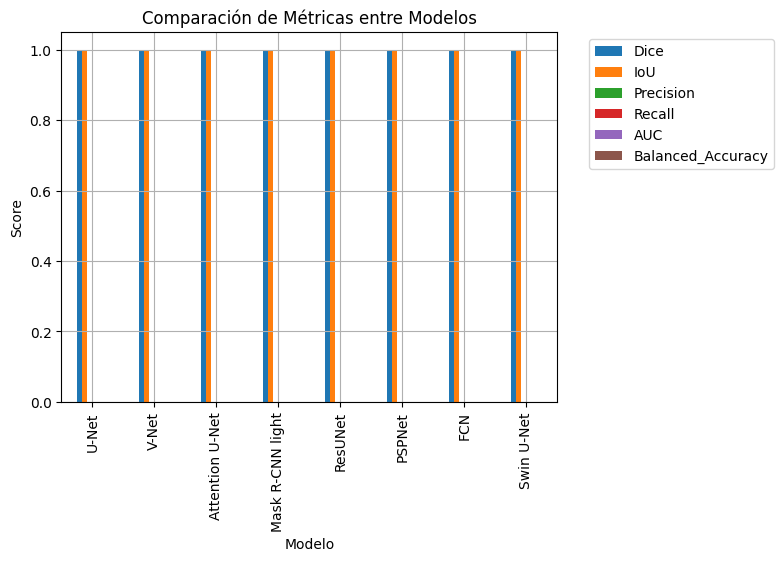

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
results_df.plot(kind='bar')
plt.title("Comparación de Métricas entre Modelos")
plt.ylabel("Score")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Iniciamos el entrenamiento de los modelos con la validacion cruzada

In [ ]:
import tensorflow as tf
import numpy as np

# 1. Redimensionar imágenes
X_resized = tf.image.resize(X, (256, 256)).numpy()

# 2. Redimensionar máscaras
Y_resized = tf.image.resize(Y[..., np.newaxis], (256, 256), method='nearest').numpy()
Y_resized = Y_resized.squeeze(-1)  # (opcional)

# 3. Usar estos nuevos arrays
folds = np.array_split(np.arange(len(X_resized)), 3)

results = {}

for model_name, build_fn in models_dict.items():
    print(f"🏗 Entrenando modelo: {model_name}")
    metrics_folds = []

    for i in range(3):
        print(f"   🔹 Fold {i+1}/3")

        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(3) if j != i])

        X_train, Y_train = X_resized[train_idx], Y_resized[train_idx]
        X_val, Y_val = X_resized[val_idx], Y_resized[val_idx]

        model = build_fn()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(X_train, Y_train, epochs=3, batch_size=8, verbose=1)

        preds = model.predict(X_val)
        preds_bin = (preds >= 0.5).astype(np.uint8)

        fold_metrics = compute_all_metrics(Y_val, preds_bin, preds)
        metrics_folds.append(fold_metrics)

    results[model_name] = average_metrics(metrics_folds)

print("\n✅ Validación cruzada completada para todos los modelos.")

🏗 Entrenando modelo: U-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9990 - loss: 0.0035
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 1.0000 - loss: 5.9530e-05
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9998 - loss: 0.0014
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: V-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9996 - loss: 9.8584e-04
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 575ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 1.0000 - loss: 3.2336e-05
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9999 - loss: 4.3831e-04
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: Attention U-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9603 - loss: 0.5138
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9607 - loss: 0.4155
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9605 - loss: 0.5663
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: Mask R-CNN light
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9963 - loss: 0.0190
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 1.0000 - loss: 2.3553e-06
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 1.0000 - loss: 2.8403e-05
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: ResUNet
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9618 - loss: 0.4992
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9999 - loss: 2.8944e-04
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9644 - loss: 0.3689
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: PSPNet
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9599 - loss: 0.6326
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9614 - loss: 0.4099
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9691 - loss: 0.2430
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: FCN
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9996 - loss: 0.0013
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9601 - loss: 0.6341
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9998 - loss: 0.0014
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: Swin U-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9600 - loss: 0.6343
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9601 - loss: 0.6352
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9748 - loss: 0.1827
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



✅ Validación cruzada completada para todos los modelos.


/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


In [ ]:
def compute_all_metrics(y_true, y_pred_bin, y_pred_proba):
    dice = dice_coef(y_true, y_pred_bin).numpy()
    iou = iou_coef(y_true, y_pred_bin).numpy()
    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    auc = roc_auc_score(y_true.flatten(), y_pred_proba.flatten())
    balanced_acc = balanced_accuracy_score(y_true.flatten(), y_pred_bin.flatten())
    return {'dice': dice, 'iou': iou, 'precision': precision, 'recall': recall, 'auc': auc, 'balanced_accuracy': balanced_acc}

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
TP = np.sum((preds_bin == 1) & (Y_val == 1))
FP = np.sum((preds_bin == 1) & (Y_val == 0))
FN = np.sum((preds_bin == 0) & (Y_val == 1))
TN = np.sum((preds_bin == 0) & (Y_val == 0))

ValueError: operands could not be broadcast together with shapes (544,256,256,1) (544,256,256) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicción')

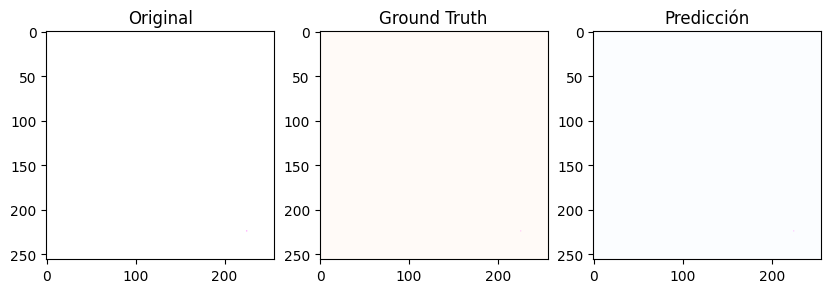

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(10,4))
axs[0].imshow(image); axs[0].set_title("Original")
axs[1].imshow(image); axs[1].imshow(mask_gt, alpha=0.5, cmap='Reds'); axs[1].set_title("Ground Truth")
axs[2].imshow(image); axs[2].imshow(mask_pred, alpha=0.5, cmap='Blues'); axs[2].set_title("Predicción")

/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Text(0.5, 1.0, 'ROC')

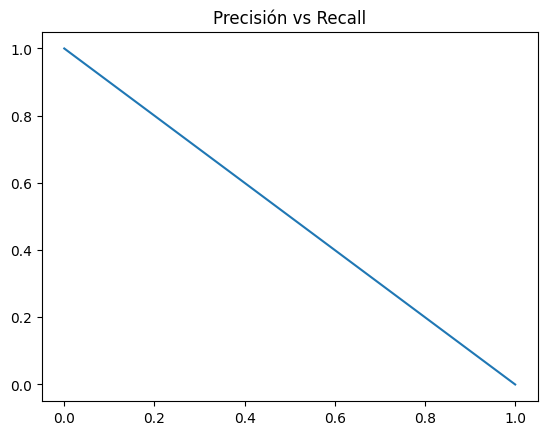

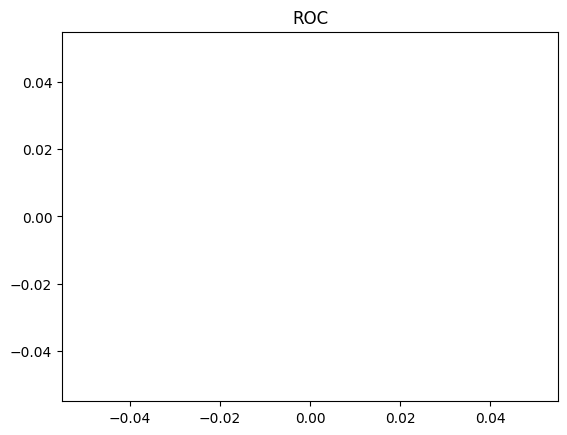

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
prec, rec, thr = precision_recall_curve(Y_val.flatten(), preds.flatten())
fpr, tpr, thr_roc = roc_curve(Y_val.flatten(), preds.flatten())
plt.figure(); plt.plot(rec, prec); plt.title("Precisión vs Recall")
plt.figure(); plt.plot(fpr, tpr); plt.title("ROC")

In [ ]:
# ----------------------------
# IMPORTS NECESARIOS
# ----------------------------
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# FUNCIONES DE MÉTRICAS
# ----------------------------

def dice_coefficient(y_true, y_pred):
    smooth = 1e-7
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred):
    smooth = 1e-7
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance(y_true, y_pred):
    try:
        points_true = np.argwhere(y_true)
        points_pred = np.argwhere(y_pred)
        if points_true.shape[0] == 0 or points_pred.shape[0] == 0:
            return np.nan  # No contornos
        forward = directed_hausdorff(points_true, points_pred)[0]
        backward = directed_hausdorff(points_pred, points_true)[0]
        return max(forward, backward)
    except Exception:
        return np.nan

def compute_all_metrics(y_true, y_pred_probs, threshold=0.5):
    y_pred = (y_pred_probs > threshold).astype(np.uint8)
    
    dice = dice_coefficient(y_true, y_pred)
    iou = iou_score(y_true, y_pred)
    precision = precision_score(y_true.flatten(), y_pred.flatten(), zero_division=0)
    recall = recall_score(y_true.flatten(), y_pred.flatten(), zero_division=0)
    auc = roc_auc_score(y_true.flatten(), y_pred_probs.flatten())
    hausdorff = hausdorff_distance(y_true.squeeze(), y_pred.squeeze())
    balanced_acc = balanced_accuracy_score(y_true.flatten(), y_pred.flatten())
    
    return dice, iou, precision, recall, auc, hausdorff, balanced_acc

In [ ]:
preds_bin = preds_bin.squeeze()
Y_val = Y_val.squeeze()

In [ ]:
all_metrics = []

for i in range(len(Y_val)):
    dice, iou, precision, recall, auc, hausdorff, balanced_acc = compute_all_metrics(Y_val[i], preds_bin[i])
    all_metrics.append([dice, iou, precision, recall, auc, hausdorff, balanced_acc])

# Crear DataFrame
metrics_df = pd.DataFrame(all_metrics, columns=["Dice", "IoU", "Precision", "Recall", "AUC", "Hausdorff", "Balanced Accuracy"])

# Mostrar resumen
print(metrics_df.describe())

/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/ana

        Dice    IoU  Precision  Recall  AUC  Hausdorff  Balanced Accuracy
count  544.0  544.0      544.0   544.0  0.0        0.0              544.0
mean     1.0    1.0        0.0     0.0  NaN        NaN                1.0
std      0.0    0.0        0.0     0.0  NaN        NaN                0.0
min      1.0    1.0        0.0     0.0  NaN        NaN                1.0
25%      1.0    1.0        0.0     0.0  NaN        NaN                1.0
50%      1.0    1.0        0.0     0.0  NaN        NaN                1.0
75%      1.0    1.0        0.0     0.0  NaN        NaN                1.0
max      1.0    1.0        0.0     0.0  NaN        NaN                1.0


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/ana

/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

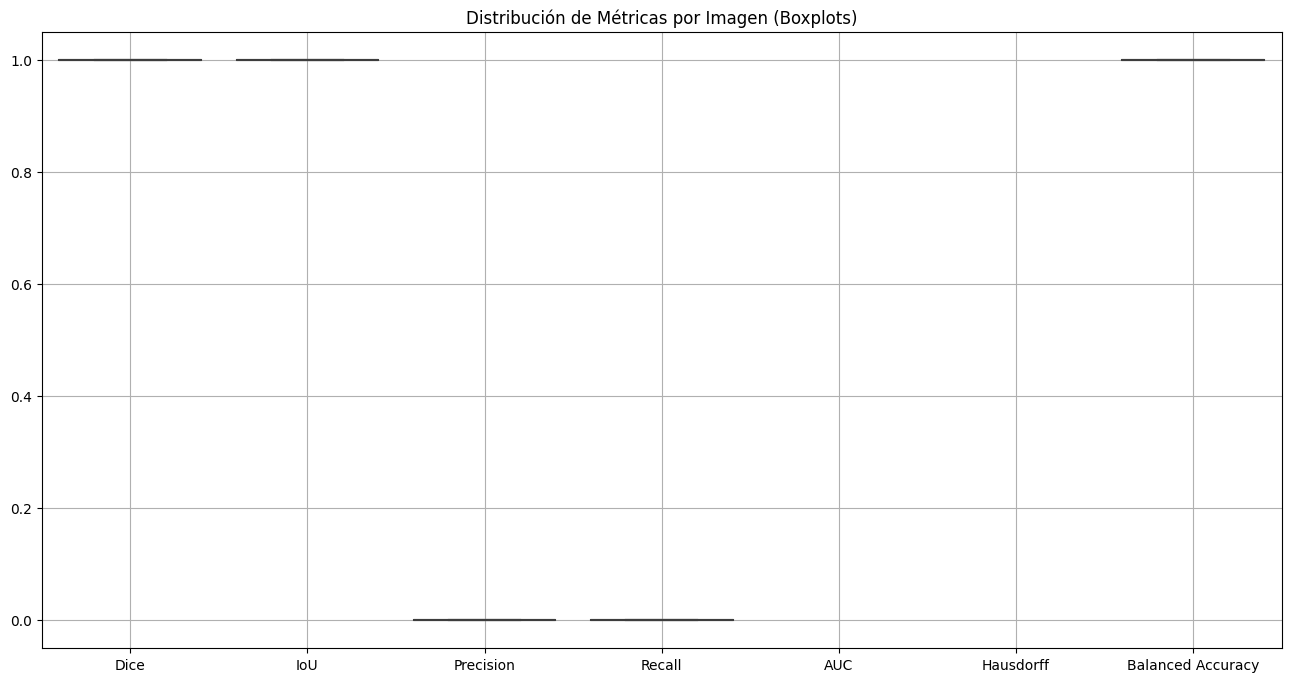

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(data=metrics_df)
plt.title("Distribución de Métricas por Imagen (Boxplots)")
plt.grid()
plt.show()

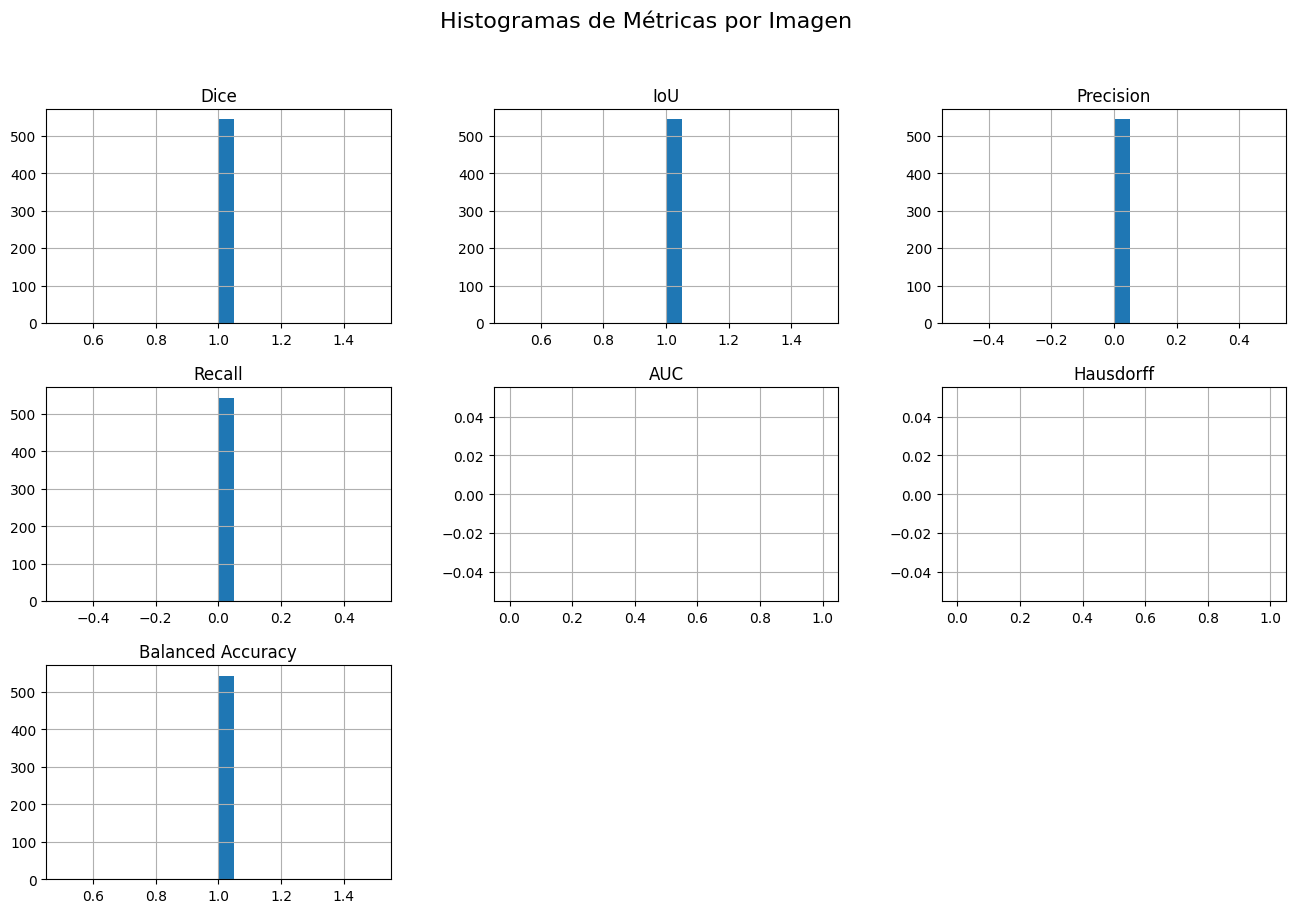

In [ ]:
metrics_df.hist(bins=20, figsize=(16,10))
plt.suptitle("Histogramas de Métricas por Imagen", fontsize=16)
plt.show()

In [ ]:
fp = (mask_pred == 1) & (mask_gt == 0)
fn = (mask_pred == 0) & (mask_gt == 1)
error_map = np.zeros(image.shape, dtype=np.uint8)
error_map[fp] = [255, 0, 0]    # rojo
error_map[fn] = [0, 0, 255]    # azul
blended = cv2.addWeighted(image, 0.7, error_map, 0.3, 0)  # combinar con original
plt.imshow(blended); plt.title("Errores (FP=rojo, FN=azul)")

IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 256

In [ ]:
metrics = {'U-Net': [dice_vals_fold1, dice_vals_fold2, dice_vals_fold3], ...}
plt.boxplot([metrics[m] for m in metrics], labels=list(metrics.keys()))
plt.title("Distribución de Dice por modelo (3-folds)")

SyntaxError: invalid syntax (722943952.py, line 1)

In [ ]:
plt.hist(metrics['U-Net'], bins=20, alpha=0.5, label='U-Net')
plt.hist(metrics['DeepLabV3+'], bins=20, alpha=0.5, label='DeepLabV3+')
plt.legend(); plt.title("Distribución IoU")

NameError: name 'metrics' is not defined

In [ ]:
plt.hist(metrics['U-Net'], bins=20, alpha=0.5, label='U-Net')
plt.hist(metrics['DeepLabV3+'], bins=20, alpha=0.5, label='DeepLabV3+')
plt.legend()
plt.title("Distribución IoU")
plt.show()

NameError: name 'metrics' is not defined

Archivos en test: ['72e40acccadf.tif']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


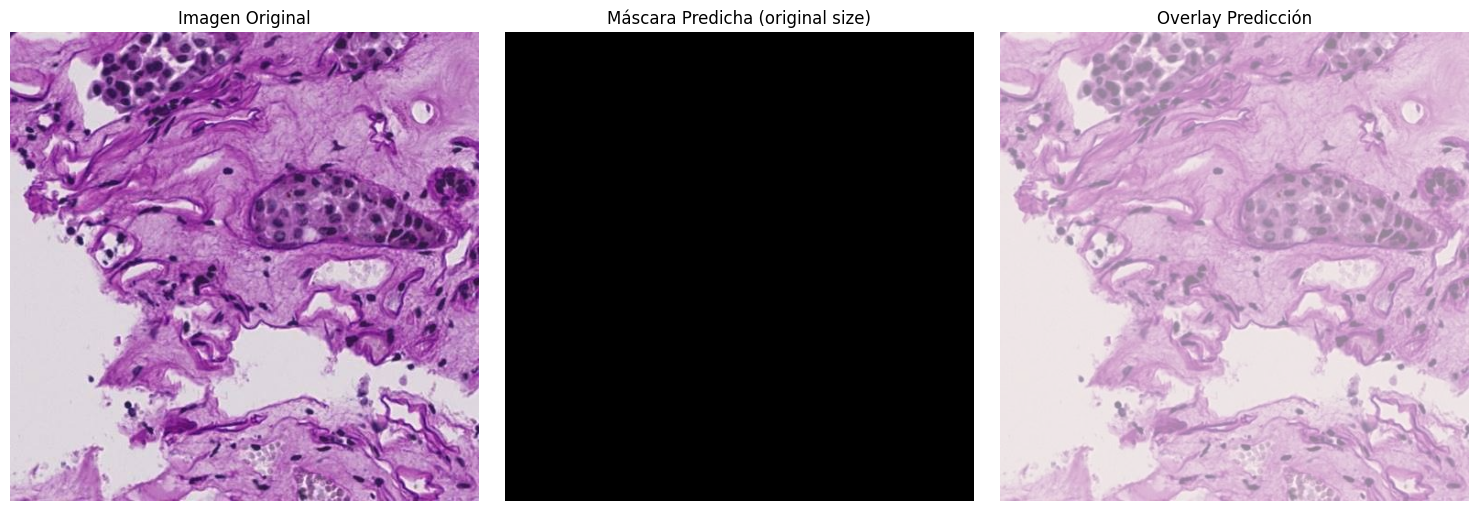

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Ruta de test
test_path = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/test'

# Listar archivos
test_files = sorted(os.listdir(test_path))
print("Archivos en test:", test_files)

# Tomar un archivo (por ejemplo, el primero)
test_image_path = os.path.join(test_path, test_files[0])

# Leer imagen
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_img = img.copy()

# Redimensionar igual que en entrenamiento (256x256)
img_resized = cv2.resize(img, (256, 256))
img_resized = img_resized / 255.0  # Normalizar [0,1]

# Expandir dimensiones para que sea batch de 1
img_input = np.expand_dims(img_resized, axis=0)  # (1, 256, 256, 3)

# Predecir
pred_mask = model.predict(img_input)
pred_mask = (pred_mask >= 0.5).astype(np.uint8)  # Binarizar

# Quitar dimensiones extra
pred_mask = pred_mask.squeeze()

# Volver a tamaño original si quieres
pred_mask_full = cv2.resize(pred_mask, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST)

# -------------------
# Visualización
# -------------------

plt.figure(figsize=(15,5))

# Imagen original
plt.subplot(1,3,1)
plt.imshow(original_img)
plt.title('Imagen Original')
plt.axis('off')

# Predicción redimensionada
plt.subplot(1,3,2)
plt.imshow(pred_mask_full, cmap='gray')
plt.title('Máscara Predicha (original size)')
plt.axis('off')

# Superposición de predicción sobre imagen
plt.subplot(1,3,3)
plt.imshow(original_img)
plt.imshow(pred_mask_full, cmap='Reds', alpha=0.5)
plt.title('Overlay Predicción')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# CONFIGURACIÓN
# -------------------------------
test_path = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/test'
output_mask_path = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/test_predictions'

os.makedirs(output_mask_path, exist_ok=True)  # Crear carpeta si no existe

img_size = (256, 256)  # Tamaño que usa tu modelo

# Listar archivos de test
test_files = sorted(os.listdir(test_path))

print(f"🔍 Total imágenes de test encontradas: {len(test_files)}")

# -------------------------------
# PROCESAR TODAS LAS IMÁGENES
# -------------------------------

for filename in test_files:
    print(f"🖼️ Procesando {filename}...")

    # Leer imagen
    img_path = os.path.join(test_path, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = img.copy()

    # Preprocesar igual que en entrenamiento
    img_resized = cv2.resize(img, img_size)
    img_resized = img_resized / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Predecir
    pred_mask = model.predict(img_input)
    pred_mask = (pred_mask >= 0.5).astype(np.uint8).squeeze()

    # Volver a tamaño original
    pred_mask_full = cv2.resize(pred_mask, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Guardar máscara predicha como imagen
    save_path = os.path.join(output_mask_path, filename.replace('.tiff', '_mask.png'))
    cv2.imwrite(save_path, pred_mask_full * 255)  # Multiplicamos por 255 para guardar en formato binario visible

    # Visualizar algunas (opcional)
    if np.random.rand() < 0.05:  # Mostrar aleatoriamente ~5%
        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(original_img)
        plt.title('Imagen Original')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(pred_mask_full, cmap='gray')
        plt.title('Máscara Predicha')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(original_img)
        plt.imshow(pred_mask_full, cmap='Reds', alpha=0.5)
        plt.title('Overlay Predicción')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

print(f"\n✅ Predicciones guardadas en: {output_mask_path}")

🔍 Total imágenes de test encontradas: 1
🖼️ Procesando 72e40acccadf.tif...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

✅ Predicciones guardadas en: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/test_predictions
